# Notebook for Deep Learning Autoencoder Applied to NSL-KDD Dataset

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import mean_squared_error

%matplotlib inline
sns.set(style = 'whitegrid')

import sys
sys.path.append('../')

from src.modeling import build_autoencoder, evaluate_autoencoder_model
from src.utils import plot_confusion, plot_precision_recall

## Load Data

In [2]:
X_train = pd.read_csv("../data/processed/X_train.csv")
X_test = pd.read_csv("../data/processed/X_test.csv")
y_train = pd.read_csv("../data/processed/y_train.csv").squeeze()
y_test = pd.read_csv("../data/processed/y_test.csv").squeeze()

## Train on Normal Data Only

In [3]:
X_train_normal = X_train[y_train == 0]
print(f"Training on normal samples only: {X_train_normal.shape}")

Training on normal samples only: (53874, 33)


## Build Autoencoder

In [4]:
input_dim = X_train.shape[1]
autoencoder = build_autoencoder(input_dim, encoding_dim=16)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 33)]              0         
                                                                 
 dense (Dense)               (None, 64)                2176      
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 16)                1040      
                                                                 
 dense_2 (Dense)             (None, 64)                1088      
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                             

## Train Autoencoder

Epoch 1/100
190/190 [==============================] - 1s 4ms/step - loss: 0.8015 - val_loss: 0.4822
Epoch 2/100
190/190 [==============================] - 1s 3ms/step - loss: 0.4296 - val_loss: 0.3058
Epoch 3/100
190/190 [==============================] - 1s 3ms/step - loss: 0.3616 - val_loss: 0.2672
Epoch 4/100
190/190 [==============================] - 1s 3ms/step - loss: 0.3195 - val_loss: 0.2347
Epoch 5/100
190/190 [==============================] - 1s 3ms/step - loss: 0.2913 - val_loss: 0.2110
Epoch 6/100
190/190 [==============================] - 0s 3ms/step - loss: 0.2750 - val_loss: 0.2042
Epoch 7/100
190/190 [==============================] - 0s 2ms/step - loss: 0.2604 - val_loss: 0.2232
Epoch 8/100
190/190 [==============================] - 0s 2ms/step - loss: 0.2504 - val_loss: 0.1858
Epoch 9/100
190/190 [==============================] - 0s 3ms/step - loss: 0.2354 - val_loss: 0.1731
Epoch 10/100
190/190 [==============================] - 0s 2ms/step - loss: 0.2260 - val_lo

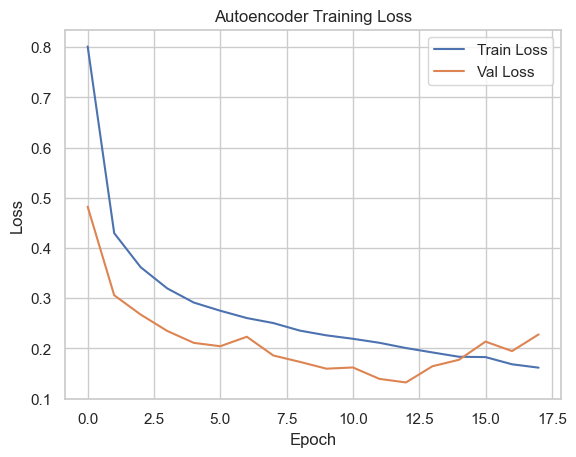

In [5]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = autoencoder.fit(
    X_train_normal, X_train_normal,
    epochs = 100,
    batch_size = 256,
    shuffle = True,
    validation_split = 0.1,
    verbose = 1,
    callbacks = [early_stop]
)

# Plot training loss
plt.plot(history.history['loss'], label = 'Train Loss')
plt.plot(history.history['val_loss'], label = 'Val Loss')
plt.title("Autoencoder Training Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()
    

## Compute Reconstruction Errors and Tune Threshold

1684/1684 [==============================] - 2s 940us/step
Threshold (99th Percentile):  0.43261
788/788 [==============================] - 1s 997us/step


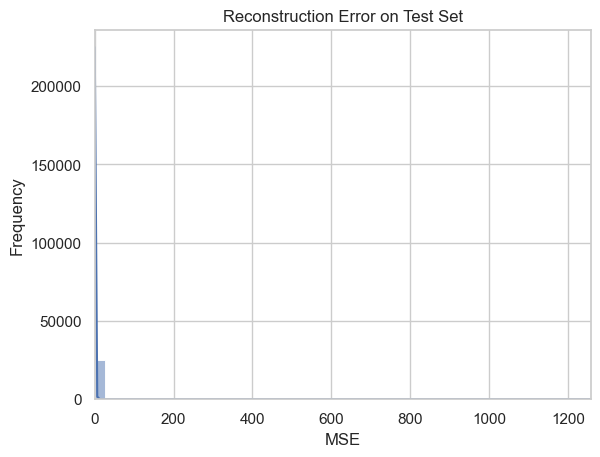

In [6]:
# get reconstruction errors for normal training data
X_train_recon = autoencoder.predict(X_train_normal)
train_recon_error = np.mean(np.square(X_train_normal - X_train_recon), axis = 1)

# Chose a threshold based on training distribution
threshold = np.percentile(train_recon_error, 99)
print(f"Threshold (99th Percentile): {threshold: .5f}")

# predict reconstructions
X_test_recon = autoencoder.predict(X_test)

# compute test reconstruction error
recon_error = np.mean(np.square(X_test - X_test_recon), axis = 1)
y_pred_ae = (recon_error > threshold).astype(int)

# Plot distribution
sns.histplot(recon_error, bins = 50, kde = True)
plt.title("Reconstruction Error on Test Set")
plt.ylabel("Frequency")
plt.xlim(0, max(recon_error))
plt.xlabel("MSE")
plt.show()

## Evaluate Model

In [7]:
metrics_ae = evaluate_autoencoder_model(y_test, y_pred_ae)

print("Autoencoder Metrics:")
for k, v in metrics_ae.items():
    print(f"{k}: {v: .3f}")

Autoencoder Metrics:
accuracy:  0.711
precision:  0.970
recall:  0.392
f1:  0.559


## Visualizations

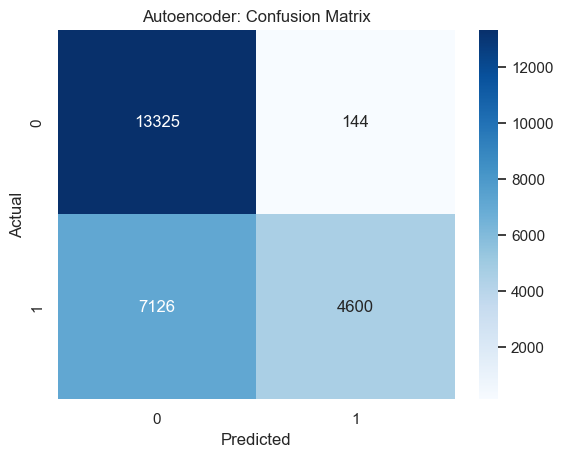

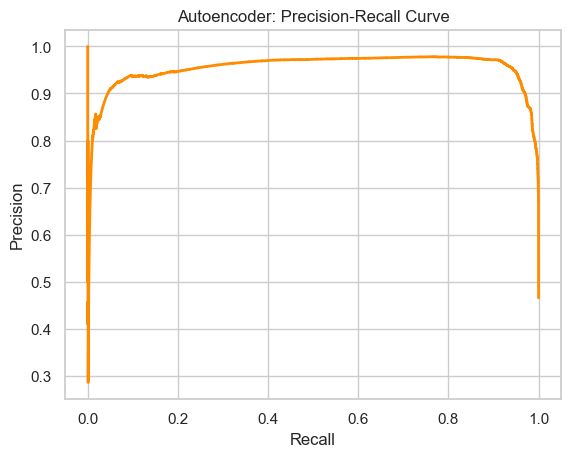

In [8]:
plot_confusion(y_test, y_pred_ae, title = "Autoencoder: Confusion Matrix")
plot_precision_recall(y_test, recon_error, title = "Autoencoder: Precision-Recall Curve")